In [55]:
import os
import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms

from sklearn.model_selection import train_test_split

# Labeling Process

In [2]:
fall_types = ['backward_falls', 'forward_falls', 'left_falls', 'right_falls', 'sitting_falls', 'standing_falls']
non_fall_types =  ['jumping', 'laying', 'picking', 'squat', 'stretching' , 'walking']

In [3]:
def get_images():
    file_paths = []
    # labels = []
    
    train_dir = os.path.join("..", "data", "train")
    subjects = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
    
    for subject in subjects:
        subject_path = os.path.join(train_dir, subject)
        subject_id = subject.split('-')[-1]  # Extract subject ID from folder name
        
        # Fall data
        fall_dir = os.path.join(subject_path, 'fall')
        for fall_type in fall_types:
            fall_type_dir = os.path.join(fall_dir, f"{subject_id}_{fall_type}")
            if os.path.exists(fall_type_dir):
                for file in os.listdir(fall_type_dir):
                    file_paths.append(os.path.join(fall_type_dir, file))
                    # labels.append(1)  # Label 1 for fall
        
        # Non-fall data
        non_fall_dir = os.path.join(subject_path, 'non_fall')
        for non_fall_type in non_fall_types:
            non_fall_type_dir = os.path.join(non_fall_dir, f"{subject_id}_{non_fall_type}")
            if os.path.exists(non_fall_type_dir):
                for file in os.listdir(non_fall_type_dir):
                    file_paths.append(os.path.join(non_fall_type_dir, file))
                    # labels.append(0)  # Label 0 for non-fall

    return file_paths#, labels

In [8]:
images = get_images()
f"There are {len(images)} images in total."

'There are 4294 images in total.'

Load model YOLO menggunakan library YOLO. 
1. Model diload dari path: `os.path.join("..", "weights", "noorkhokhar99", "fall_det_1.pt")`.
2. Model ini digunakan dengan tujuan untuk membantu labeling.
3. Sumber Model: [noorkhokhar99@github](https://github.com/noorkhokhar99/Fall_Detection_Using_Yolov8).

In [4]:
# Source (for labeling purpose): https://github.com/noorkhokhar99/Fall_Detection_Using_Yolov8
model = YOLO(os.path.join("..", "weights", "noorkhokhar99", "fall_det_1.pt"))

c:\Users\tsfai\Projects\data-slayer-2.0\venv\Lib\site-packages\ultralytics\nn\tasks.py:714: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_locatio

Kode untuk menghasilkan daftar image path, label hasil prediksi label, dan tingkat kepercayaan masing-masing hasil prediksi.

In [ ]:
image_paths, labels, confidence_levels = [], [], []

for i, image in enumerate(images):
    image_paths.append(image)
    results = model(image)

    is_fall = int(len(results[0].boxes) > 0)
    labels.append(is_fall)

    if is_fall:
        confidence_levels.append(results[0].boxes[0].conf)
    else:
        confidence_levels.append(0)

Memastikan semua nilai dalam daftar `confidence_levels` dikonversi menjadi tipe data **float** untuk memastikan konsistensi tipe data saat nilai digunakan lebih lanjut.

In [ ]:
confidence_levels = [float(item) if isinstance(item, (int, float)) else float(item.item()) for item in confidence_levels]

Menyimpan data sebagai file CSV bernama `data_train.csv`

In [ ]:
data_train = pd.DataFrame({
    'path': image_paths,
    'label': labels,
    'conf': confidence_levels
})

data_train.head()

,path,label,conf
0,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000
1,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000
2,.\data\train\subject-1\fall\1_backward_falls\f...,1,0.444923
3,.\data\train\subject-1\fall\1_backward_falls\f...,1,0.616470
4,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000


In [ ]:
data_train.to_csv(os.path.join(".", "data", "data_train.csv"), index=False)

# Exploratory Data Analysis 

In [30]:
data = pd.read_csv('../data/.old/data_train.csv')
data.head()

,path,label,conf
0,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000
1,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000
2,.\data\train\subject-1\fall\1_backward_falls\f...,1,0.444923
3,.\data\train\subject-1\fall\1_backward_falls\f...,1,0.616470
4,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000


Memisahkan data yang berasal dari folder fall dan folder non_fall

In [31]:
fall_data = data[data['path'].str.contains('\\fall\\', regex=False)]
non_fall_data = data[data['path'].str.contains(r'\\non_fall\\', regex=False)]

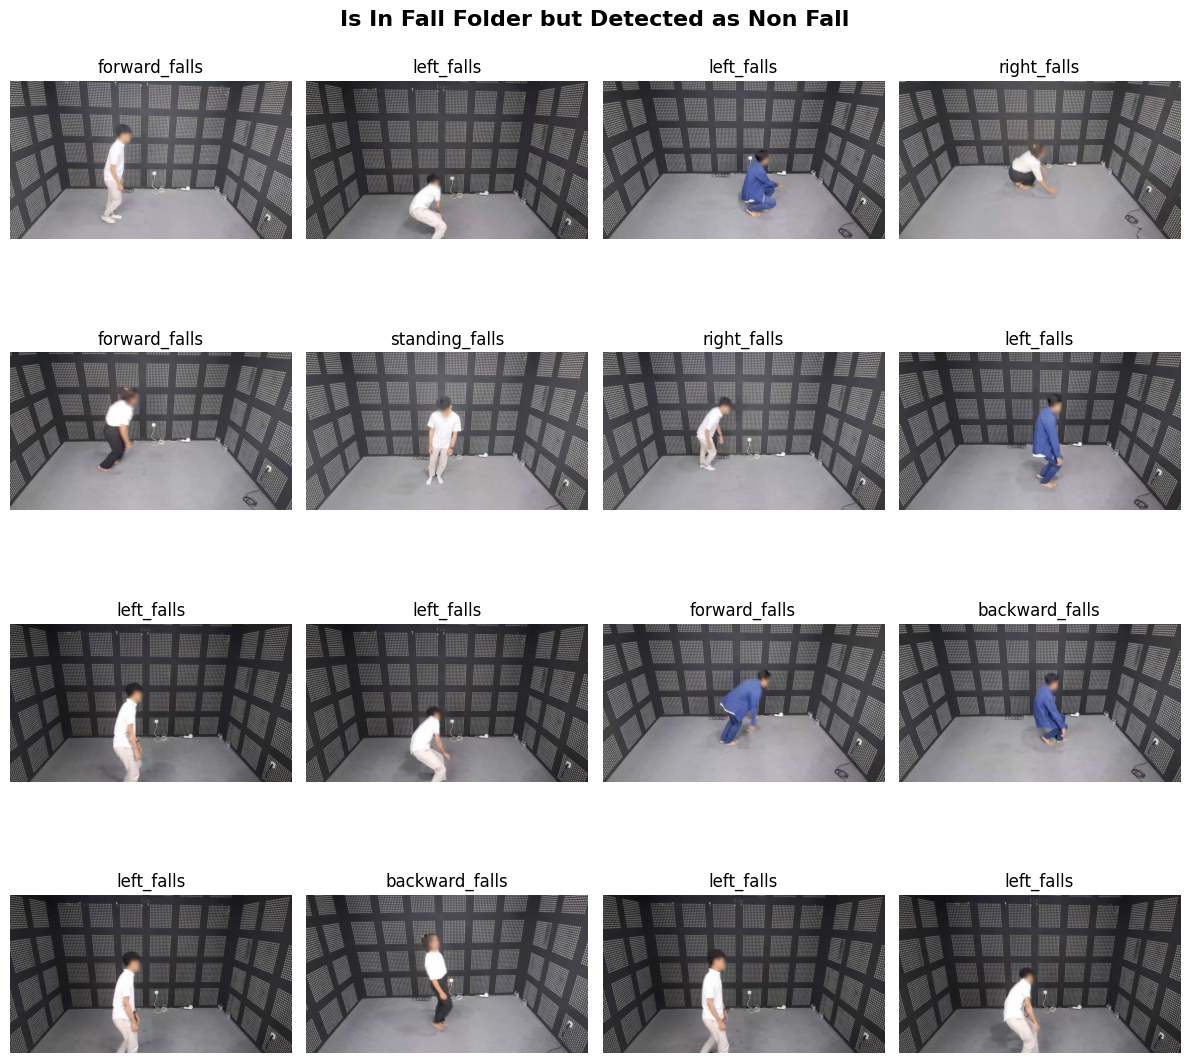

In [33]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
samples = fall_data[fall_data['label'] == 0].sample(n=16, random_state=1)['path'].values

for ax, file_path in zip(axes.flatten(), samples):
    try:
        img = Image.open("../" + file_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(file_path.split('\\')[-2][2:])
    except Exception as e:
        ax.set_title("Error")
        print(e)
        ax.axis('off')
        
plt.suptitle("Is In Fall Folder but Detected as Non Fall", fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

Dari visualisasi di atas, dapat disimpulkan bahwa model pretrained untuk labeling sebelumnya belum sepenuhnya akurat, karena masih terdapat beberapa gambar yang tidak menunjukkan fall tetapi terdeteksi sebagai fall.



In [45]:
sus_data = data[data['path'].str.contains('\\non_fall\\', regex=False)]
sus_data = sus_data[sus_data['label'] == 1]

f"Apakah ada image yang terdeteksi fall tetapi sebenarnya ada di non_fall folder? {len(sus_data) > 0}"

'Apakah ada image yang terdeteksi fall tetapi sebenarnya ada di non_fall folder? False'

In [46]:
data[data['path'].str.contains('\\non_fall\\', regex=False)].describe()

,label,conf
count,2748.0,2748.000000
mean,0.0,0.198041
std,0.0,0.322220
min,0.0,0.000000
25%,0.0,0.000000
50%,0.0,0.000000
75%,0.0,0.372402
max,0.0,0.885053


Dari kode-kode di atas, dapat dilihat bahwa jika gambar pada awalnya berada di folder non_fall, maka semuanya telah terkategorikan dengan benar sebagai non_fall. Namun, karena kemungkinan terjadinya salah prediksi (misalnya salah labeling), perlu dilakukan validasi ulang.

# Revalidating Label

Proses validasi ulang label dilakukan dengan memeriksa gambar satu per satu yang dianggap eligible atau mencurigakan. Proses ini dilakukan menggunakan FastAPI di file Python yang terpisah, namun kami akan mencantumkan konten dari file Python tersebut di bawah ini.

Proses validasi ulang label dilakukan dengan menggunakan **FastAPI** dalam file Python terpisah. Berikut adalah langkah-langkah utama yang dilakukan:

- Data yang akan divalidasi diambil dari file CSV `data_train.csv` yang berisi gambar yang terdeteksi sebagai **non_fall** tetapi perlu diverifikasi ulang. 
- Kolom baru `revalidated_manually` ditambahkan untuk menandai apakah gambar telah divalidasi ulang secara manual.
- **GET `/`**: Menampilkan gambar yang perlu divalidasi ulang, dengan dua tombol untuk memilih label: **Fall** atau **Non-Fall**.
- Gambar yang ditampilkan berasal dari folder **fall**, dan hanya gambar dengan label yang belum divalidasi ulang yang akan ditampilkan.
- **POST `/submit`**: Ketika tombol diklik, label yang dipilih dikirim ke server. Label tersebut akan memperbarui data dan menyimpannya di file CSV.
- Data yang telah divalidasi ulang akan disimpan dan diupdate pada file CSV.


In [ ]:
from fastapi import FastAPI, Request
from fastapi.responses import HTMLResponse, JSONResponse
from fastapi.staticfiles import StaticFiles
from pydantic import BaseModel
import pandas as pd
import random
import json

csv_file = "./data/data_train.csv"
data = pd.read_csv(csv_file)

if 'revalidated_manually' not in data.columns:
    data['revalidated_manually'] = 0

data_to_validate = data[data['path'].str.contains('\\fall\\', regex=False)].copy()
data_to_validate = data_to_validate[data_to_validate['label'] == 0]

app = FastAPI()
app.mount("/images", StaticFiles(directory="."), name="images")

class LabelInput(BaseModel):
    index: int
    label: int

@app.get("/", response_class=HTMLResponse)
async def read_item():
    remaining_data = data_to_validate[data_to_validate["revalidated_manually"] == False]
    
    if remaining_data.empty:
        print(len(remaining_data))
        return HTMLResponse("<h1>Semua gambar sudah divalidasi!</h1>")

    current_index = remaining_data.index[random.randint(0, len(remaining_data)-1)]
    current_image_path = remaining_data.loc[current_index, "path"]
    current_image_label = remaining_data.loc[current_index, "label"]
    
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Revalidasi Data</title>
    </head>
    <body>
        <h1>Revalidasi Data</h1>
        <p>{len(remaining_data)} images left.</p>
        <p>{current_image_path.split('\\')[-2][2:]}, src: <a href="{current_image_path}" target="_blank">{current_image_path}</a></p>
        <p>Detected as {"Fall" if current_image_label else "Non-Fall"}</p>
        <img src="/images/{current_image_path}" alt="Image" style="max-width: 600px; max-height: 400px;"/>
        <br/>
        <button onclick="submitLabel({current_index}, 1)">Fall</button>
        <button onclick="submitLabel({current_index}, 0)">Non Fall</button>
        <button onclick="submitLabel({current_index}, -1)">Skip</button>
        <script>
            async function submitLabel(index, label) {{
                const response = await fetch('/submit', {{
                    method: 'POST',
                    headers: {{
                        'Content-Type': 'application/json'
                    }},
                    body: JSON.stringify({{ index: index, label: label }})
                }});
                const result = await response.json();
                if (result.success) {{
                    window.location.reload();
                }} else {{
                    alert("Gagal menyimpan data.");
                }}
            }}
        </script>
    </body>
    </html>
    """
    return HTMLResponse(content=html_content)

@app.post("/submit")
async def submit_label(label_input: LabelInput):
    try:
        index = label_input.index
        label = label_input.label

        if label in [0,1]:
            data_to_validate.at[index, "label"] = label

        data_to_validate.at[index, "revalidated_manually"] = int(label in [0, 1])

        data.update(data_to_validate)
        data.to_csv(csv_file, index=False)

        return JSONResponse({"success": True})
    except Exception as e:
        return JSONResponse({"success": False, "error": str(e)})

# Fine-Tuning Resnet18

Model **ResNet18** yang sudah dilatih sebelumnya dipilih karena kemampuannya dalam mengenali fitur-fitur kompleks dengan struktur residual yang memungkinkan pelatihan yang lebih dalam tanpa masalah vanishing gradient. Lapisan FC terakhir diganti untuk tugas klasifikasi biner, dengan output diubah menjadi `nn.Linear(num_features, 1)` dan ditambahkan fungsi aktivasi **Sigmoid** untuk menghasilkan probabilitas antara 0 dan 1.

In [49]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1), # Untuk klasifikasi
    nn.Sigmoid()
)

c:\Users\tsfai\Projects\data-slayer-2.0\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tsfai\Projects\data-slayer-2.0\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Transformasi ini memastikan gambar berada dalam format yang tepat untuk model.
1. Gambar akan diubah ukurannya menjadi **224x224** piksel agar sesuai dengan input model ResNet18.
2. Gambar akan diubah menjadi tensor agar bisa diproses oleh model PyTorch.
3. Gambar akan dinormalisasikan dengan mean dan standar deviasi sesuai dengan nilai yang digunakan pada model pretrained ResNet18.

In [50]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Kelas **`CustomImageDataset`** dibuat agar bisa memuat gambar dan label dalam format yang sesuai untuk PyTorch yang akan menyimpan image path, label, dan transformasi yang diterapkan, mengembalikan jumlah gambar, dan membaca gambar, menerapkan transformasi jika ada, dan mengembalikan gambar beserta label (jika tersedia).

In [51]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths 
        self.labels = labels
        self.transform = transform

        for i in range(len(self.image_paths)):
            if self.labels is None:
                # Maka ini data test
                self.image_paths[i] = os.path.join("..", "data", "test", self.image_paths[i])
            else:
                # Maka ini data train
                self.image_paths[i] = "..\\" + self.image_paths[i]

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.labels is None:
            # Maka ini adalah data test, hence akan return image saja tanpa label
            return image
        else:
            label = self.labels[idx]

        return image, label

In [54]:
data_train = pd.read_csv("../data/revalidated/data_train_f_001.csv")
data_train.head()

,path,label,conf,revalidated_manually
0,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000,1
1,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000,1
2,.\data\train\subject-1\fall\1_backward_falls\f...,1,0.444923,1
3,.\data\train\subject-1\fall\1_backward_falls\f...,1,0.616470,1
4,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000,1


Dataset `data_train` dibagi menjadi data pelatihan dan data validasi menggunakan **`train_test_split`** dengan proporsi 80% untuk pelatihan dan 20% untuk validasi. Jalur gambar dan label untuk masing-masing data kemudian diambil dan disiapkan dalam list. Dataset pelatihan dan validasi dibuat menggunakan kelas **`CustomImageDataset`** dengan transformasi yang diterapkan pada gambar. Selanjutnya, **`DataLoader`** digunakan untuk memuat dataset pelatihan dan validasi dalam batch ukuran 16, dengan data pelatihan diacak dan data validasi tidak diacak untuk proses pelatihan dan evaluasi model.

In [57]:
train_data, val_data = train_test_split(data_train, test_size=0.2, random_state=42)

train_data_paths = train_data['path'].values.tolist()
val_data_paths = val_data['path'].values.tolist()

train_data_labels = train_data['label'].values.tolist()
val_data_labels = val_data['label'].values.tolist()

train_dataset = CustomImageDataset(image_paths=train_data_paths, labels=train_data_labels, transform=transform)
val_dataset = CustomImageDataset(image_paths=val_data_paths, labels=val_data_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Untuk training model akan digunakan **`BCELoss`** sebagai loss function karena ini adalah binary classification. Optimizer yang digunakan adalah **`Adam`**, dengan learning rate sebesar 0.0001, untuk memperbarui parameter model selama pelatihan.


In [59]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Memeriksa apakah GPU tersedia. Jika tersedia, perangkat yang digunakan adalah **`cuda`**, jika tidak, maka menggunakan **`cpu`**. 

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

next(model.parameters()).device

device(type='cuda', index=0)

Model dilatih selama **10 epoch**. 
Selama iterasi pelatihan, gambar dan label dipindahkan ke perangkat yang sesuai (GPU atau CPU), lalu output model dihitung dan fungsi kehilangan **`BCELoss`** diterapkan. 
Setelah setiap epoch, **`epoch_loss`** dan **`epoch_acc`** dihitung dan dicetak. Setiap 5 epoch, model diuji pada data validasi menggunakan mode **`eval()`** untuk menghitung akurasi pada data validasi, dan hasilnya dicetak sebagai **`test_acc`**.

In [72]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)


        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.unsqueeze(1).float()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()


    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}")

    if (epoch + 1) % 5 == 0:
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predicted = (outputs > 0.5).long()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_acc = correct / total * 100
        print(f"Test Accuracy: {test_acc:.2f}%")

Epoch 1/10, Loss: 0.0107, Accuracy: 99.77
Epoch 2/10, Loss: 0.0033, Accuracy: 99.85
Epoch 3/10, Loss: 0.0132, Accuracy: 99.56
Epoch 4/10, Loss: 0.0039, Accuracy: 99.91
Epoch 5/10, Loss: 0.0021, Accuracy: 99.94
Test Accuracy: 898.37%
Epoch 6/10, Loss: 0.0017, Accuracy: 99.94
Epoch 7/10, Loss: 0.0022, Accuracy: 99.91
Epoch 8/10, Loss: 0.0026, Accuracy: 99.88
Epoch 9/10, Loss: 0.0017, Accuracy: 99.97
Epoch 10/10, Loss: 0.0017, Accuracy: 99.94
Test Accuracy: 898.60%


Fungsi ini mengembalikan **`avg_loss`** (rata-rata loss) dan **`accuracy`** model pada dataset.

In [73]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = .0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).long()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    
    return avg_loss, accuracy

In [74]:
train_loss, train_acc = evaluate_model(model, train_loader, criterion)
val_loss, val_acc = evaluate_model(model, val_loader, criterion)

print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Training Loss: 0.0009, Training Accuracy: 0.9994
Validation Loss: 0.0451, Validation Accuracy: 0.9895


Model menunjukkan **Training Loss** sebesar 0.0009 dengan **Training Accuracy** mencapai 99.94%. 

Sedangkan pada data validasi, model memperoleh **Validation Loss** sebesar 0.0451 dengan **Validation Accuracy** sebesar 98.95%. 

Karena akurasi yang tinggi pada data pelatihan dan validasi serta loss yang relatif rendah, kami berasumsi model tidak mengalami overfitting. Oleh karena itu,kami langsung menuju tahap prediksi pada data uji dan membuat **submission**.

- Load data test dari file **`sample_submission.csv`**. 
- Dataset test dibuat dengan **`CustomImageDataset`**, dimana image path diambil dari kolom `id` dan tidak ada label (karena ini adalah data test). 
- Dataset test ini kemudian dimasukkan ke dalam **`DataLoader`** dengan batch size 16 dan tanpa shuffle, untuk mempersiapkan data test yang akan digunakan

In [78]:
test_data = pd.read_csv("../data/sample_submission.csv")
test_dataset = CustomImageDataset(image_paths=test_data['id'].values.tolist(), labels=None, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Melakukan prediksi pada data test. Setiap batch gambar yang diproses dimasukkan ke dalam model, dan prediksi dihitung dengan membandingkan output model terhadap threshold 0.5. Hasil prediksi (0 atau 1) disimpan dalam list yang akhirnya akan diproses menjadi format nilai pertama dari setiap prediksi untuk setiap gambar.


In [79]:
model.eval()
predictions = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)

        preds = (outputs > 0.5).long()
        predictions.extend(preds.cpu().numpy())

predictions = [pred[0] for pred in predictions]

In [81]:
test_data['label'] = predictions
test_data.to_csv("../data/submissions/001.csv", index=False)